### To build custom Skat object-detection yolo model use google colab GPU Before start please make some change in colab to access free GPU

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Nov 25 19:01:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [3]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.37 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.5/112.6 GB disk)


**NOTE:** When training YOLO11, make sure your data is located in `{HOME}/datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. When downloading data from [Roboflow Universe](https://universe.roboflow.com/), use the YOLOv8 format.

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="your_api_key")
project = rf.workspace("your_work_space_on_roboflow").project("skat-card-object-detection")
version = project.version(1)
dataset = version.download("yolov11")

/content/datasets
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Skat-Card-Object-Detection-1 in yolov11:: 100%|██████████| 1548/1548 [00:00<00:00, 6330.90it/s]


**NOTE:** Make sure to run commands below to make dataset work with YOLO11 training.

In [5]:
!sed -i '$d' {dataset.location}/data.yaml   # Delete the last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the second-to-last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the third-to-last line

!echo 'test: ../test/images' >> {dataset.location}/data.yaml
!echo 'train: ../train/images' >> {dataset.location}/data.yaml
!echo 'val: ../valid/images' >> {dataset.location}/data.yaml

## Custom Training

In [6]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=100 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 128MB/s] 
Ultralytics 8.3.37 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/Skat-Card-Object-Detection-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fals

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [7]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	 train_batch3781.jpg
confusion_matrix_normalized.png			    R_curve.png		 train_batch3782.jpg
confusion_matrix.png				    results.csv		 val_batch0_labels.jpg
events.out.tfevents.1732561464.4e80e5ef4872.1944.0  results.png		 val_batch0_pred.jpg
F1_curve.png					    train_batch0.jpg	 val_batch1_labels.jpg
labels_correlogram.jpg				    train_batch1.jpg	 val_batch1_pred.jpg
labels.jpg					    train_batch2.jpg	 weights
P_curve.png					    train_batch3780.jpg


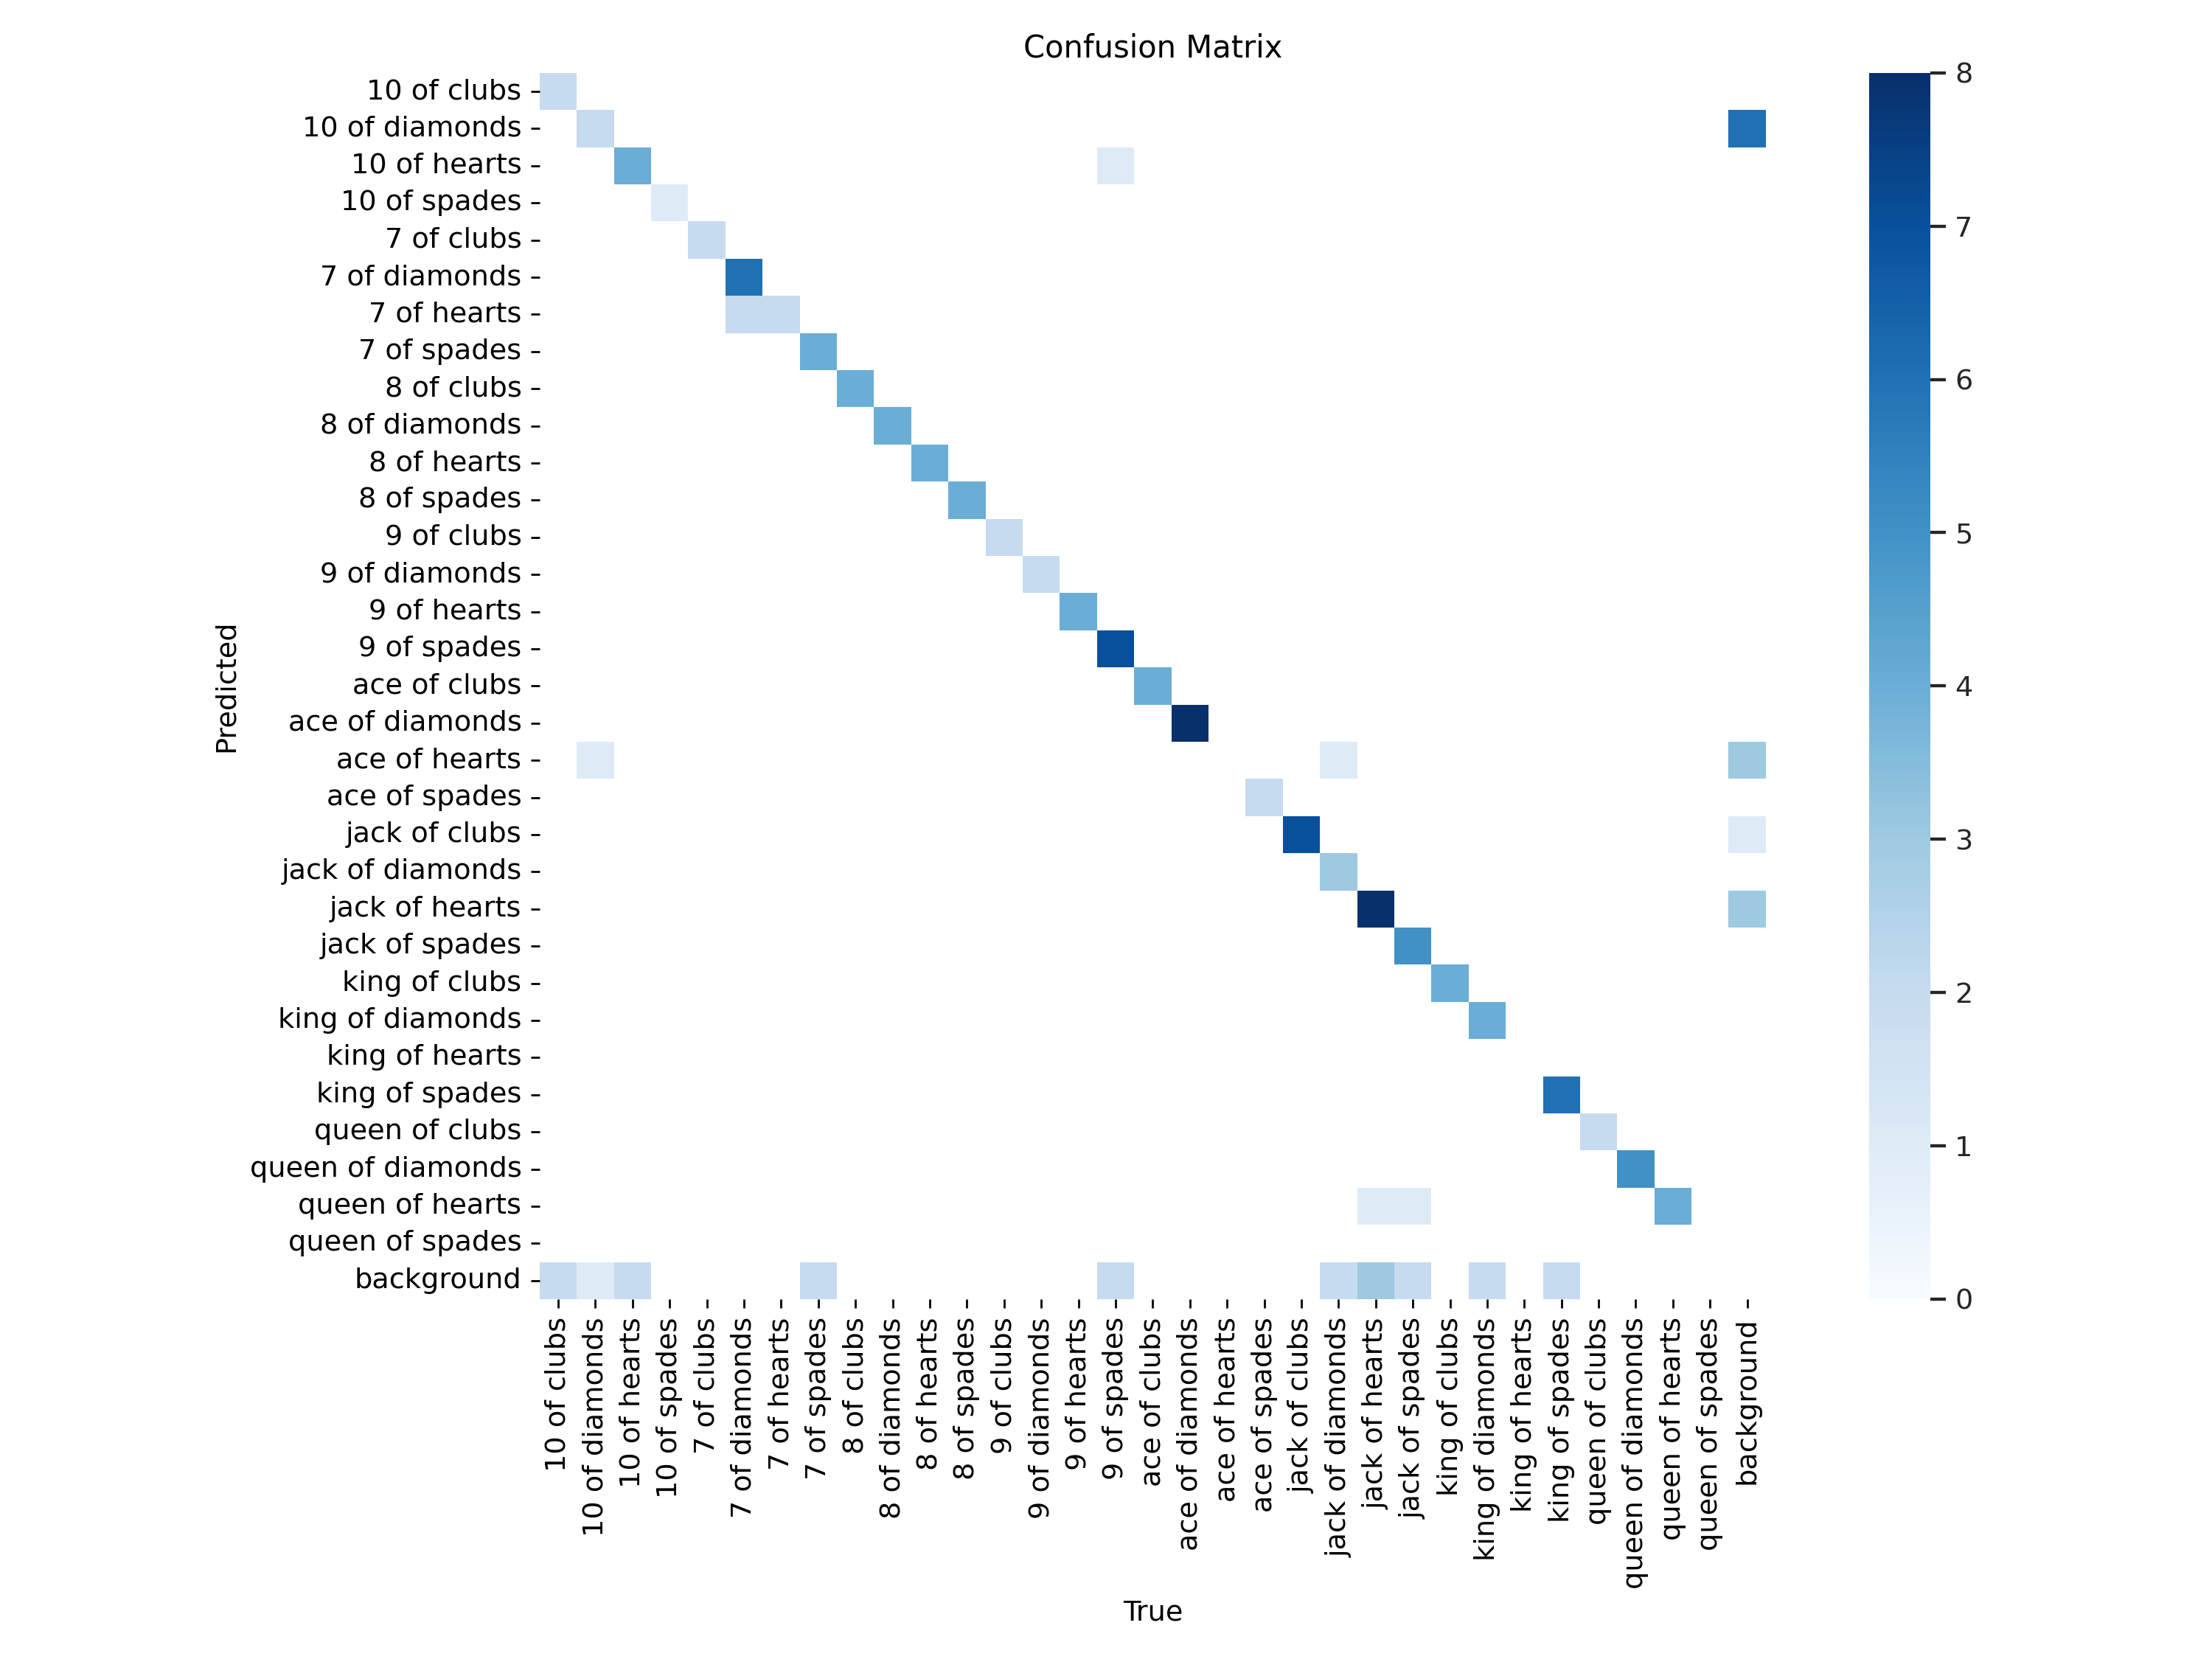

In [8]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

Here's a model summary of the confusion matrix:

1. Overall Performance: Very Good
- Strong diagonal blue line shows the model is highly accurate
- Most predictions are correct as shown by dark blue spots on the diagonal
- Very few mistakes (light blue spots) elsewhere

2. What It Does Well:
- Accurately identifies most playing cards
- Good at telling different suits apart (hearts, diamonds, clubs, spades)
- Strong at distinguishing numbers from face cards

3. Minor Challenges:
- Some small mix-ups between similar cards (like face cards)
- Occasional confusion between consecutive numbers

4. Verdict:
This seems to be a very reliable card detection system that gets it right most of the time. The few mistakes it makes are usually between similar cards, which is understandable.



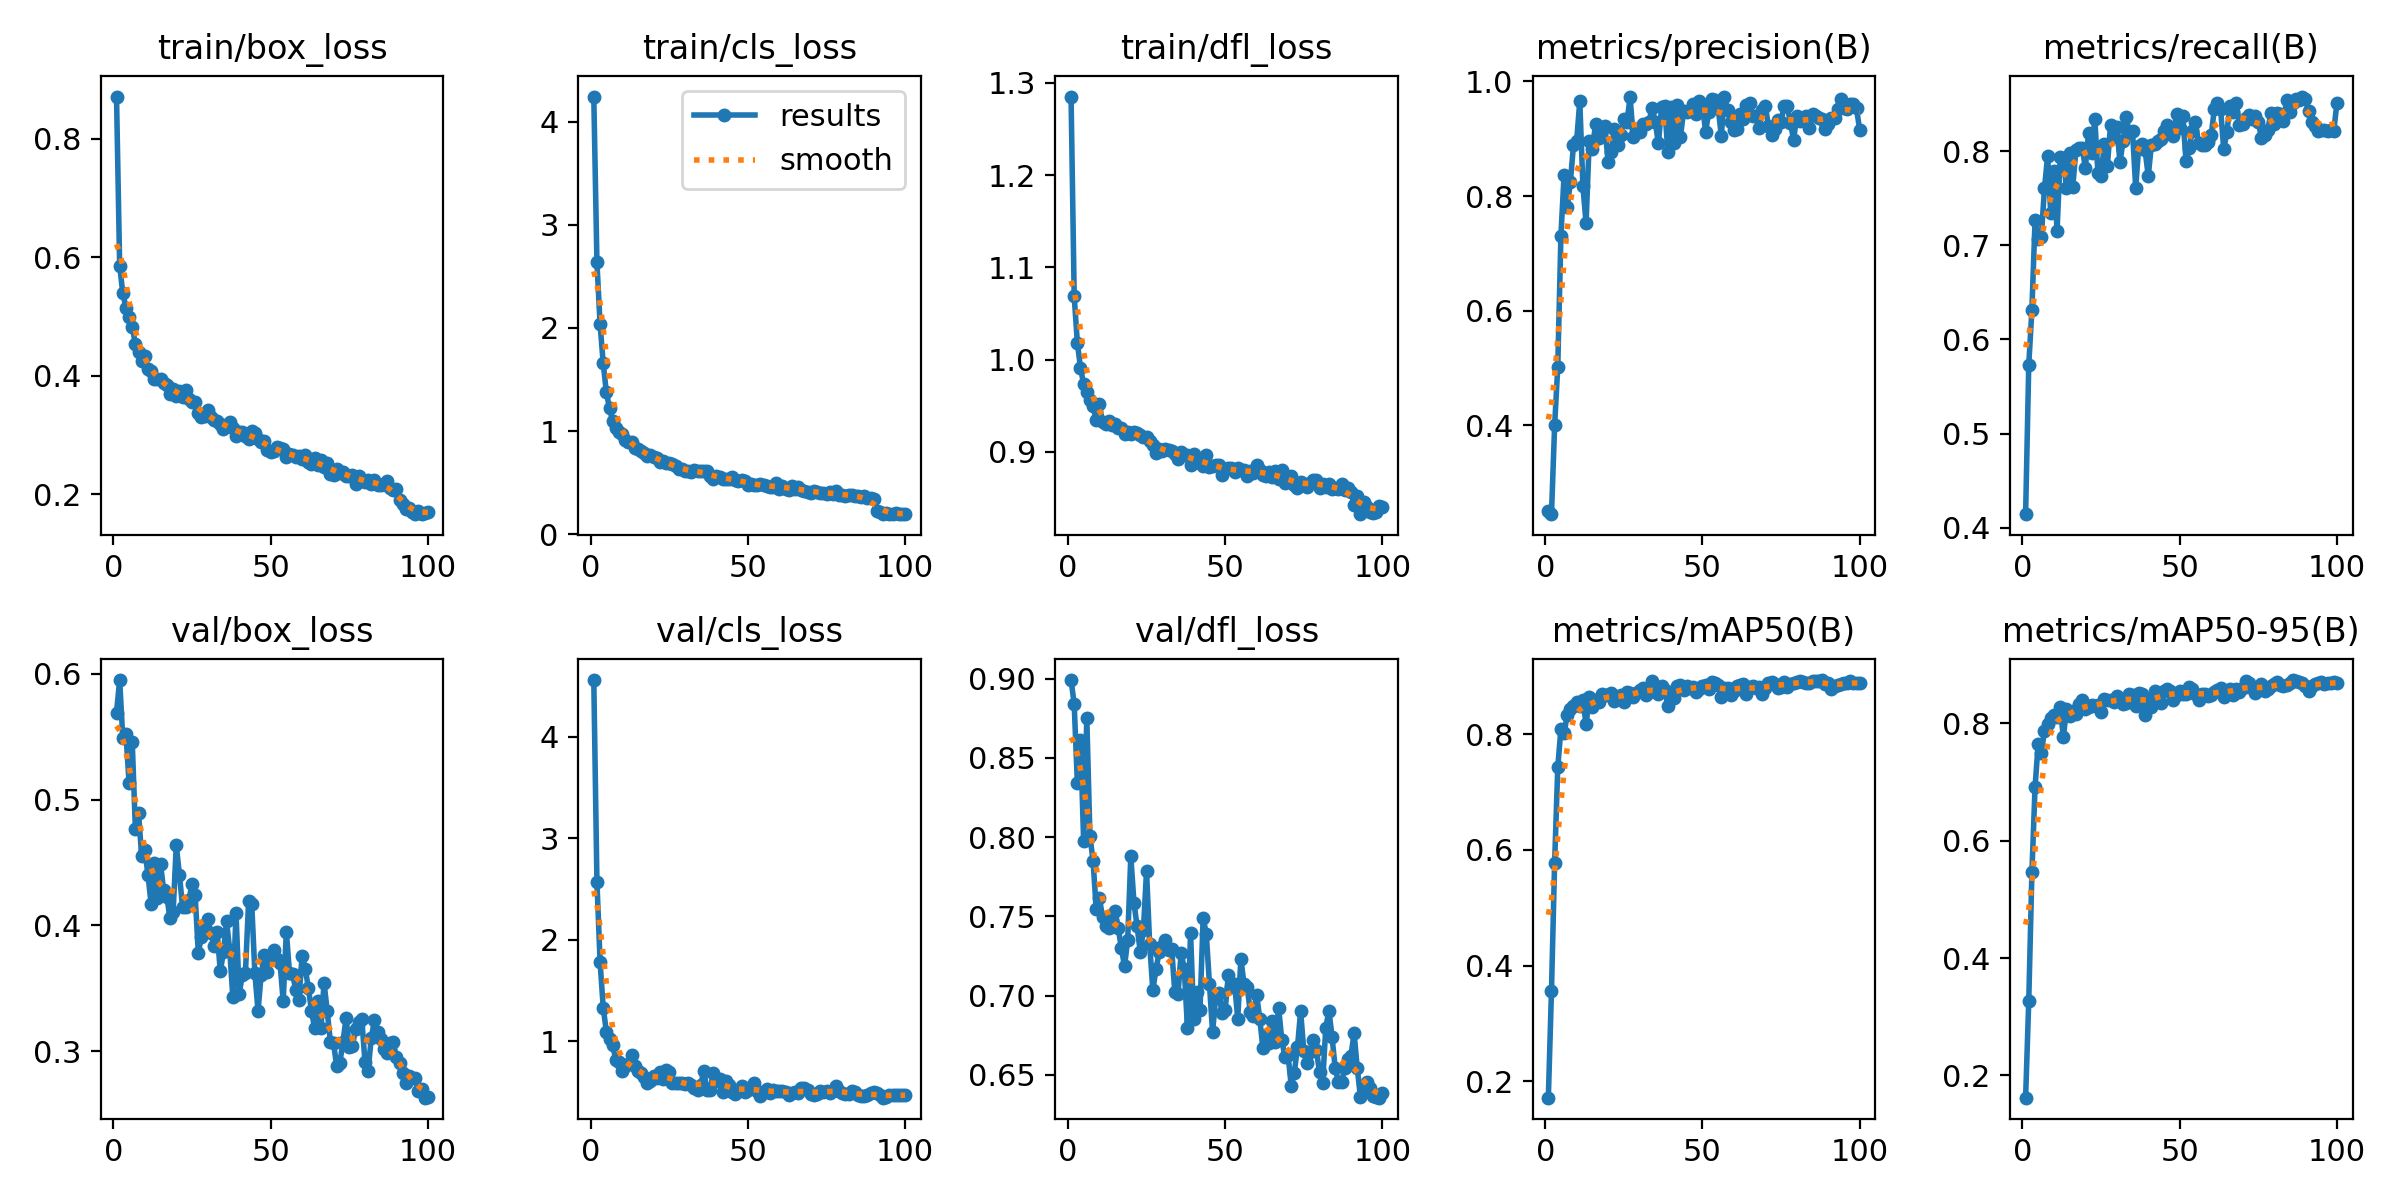

In [9]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

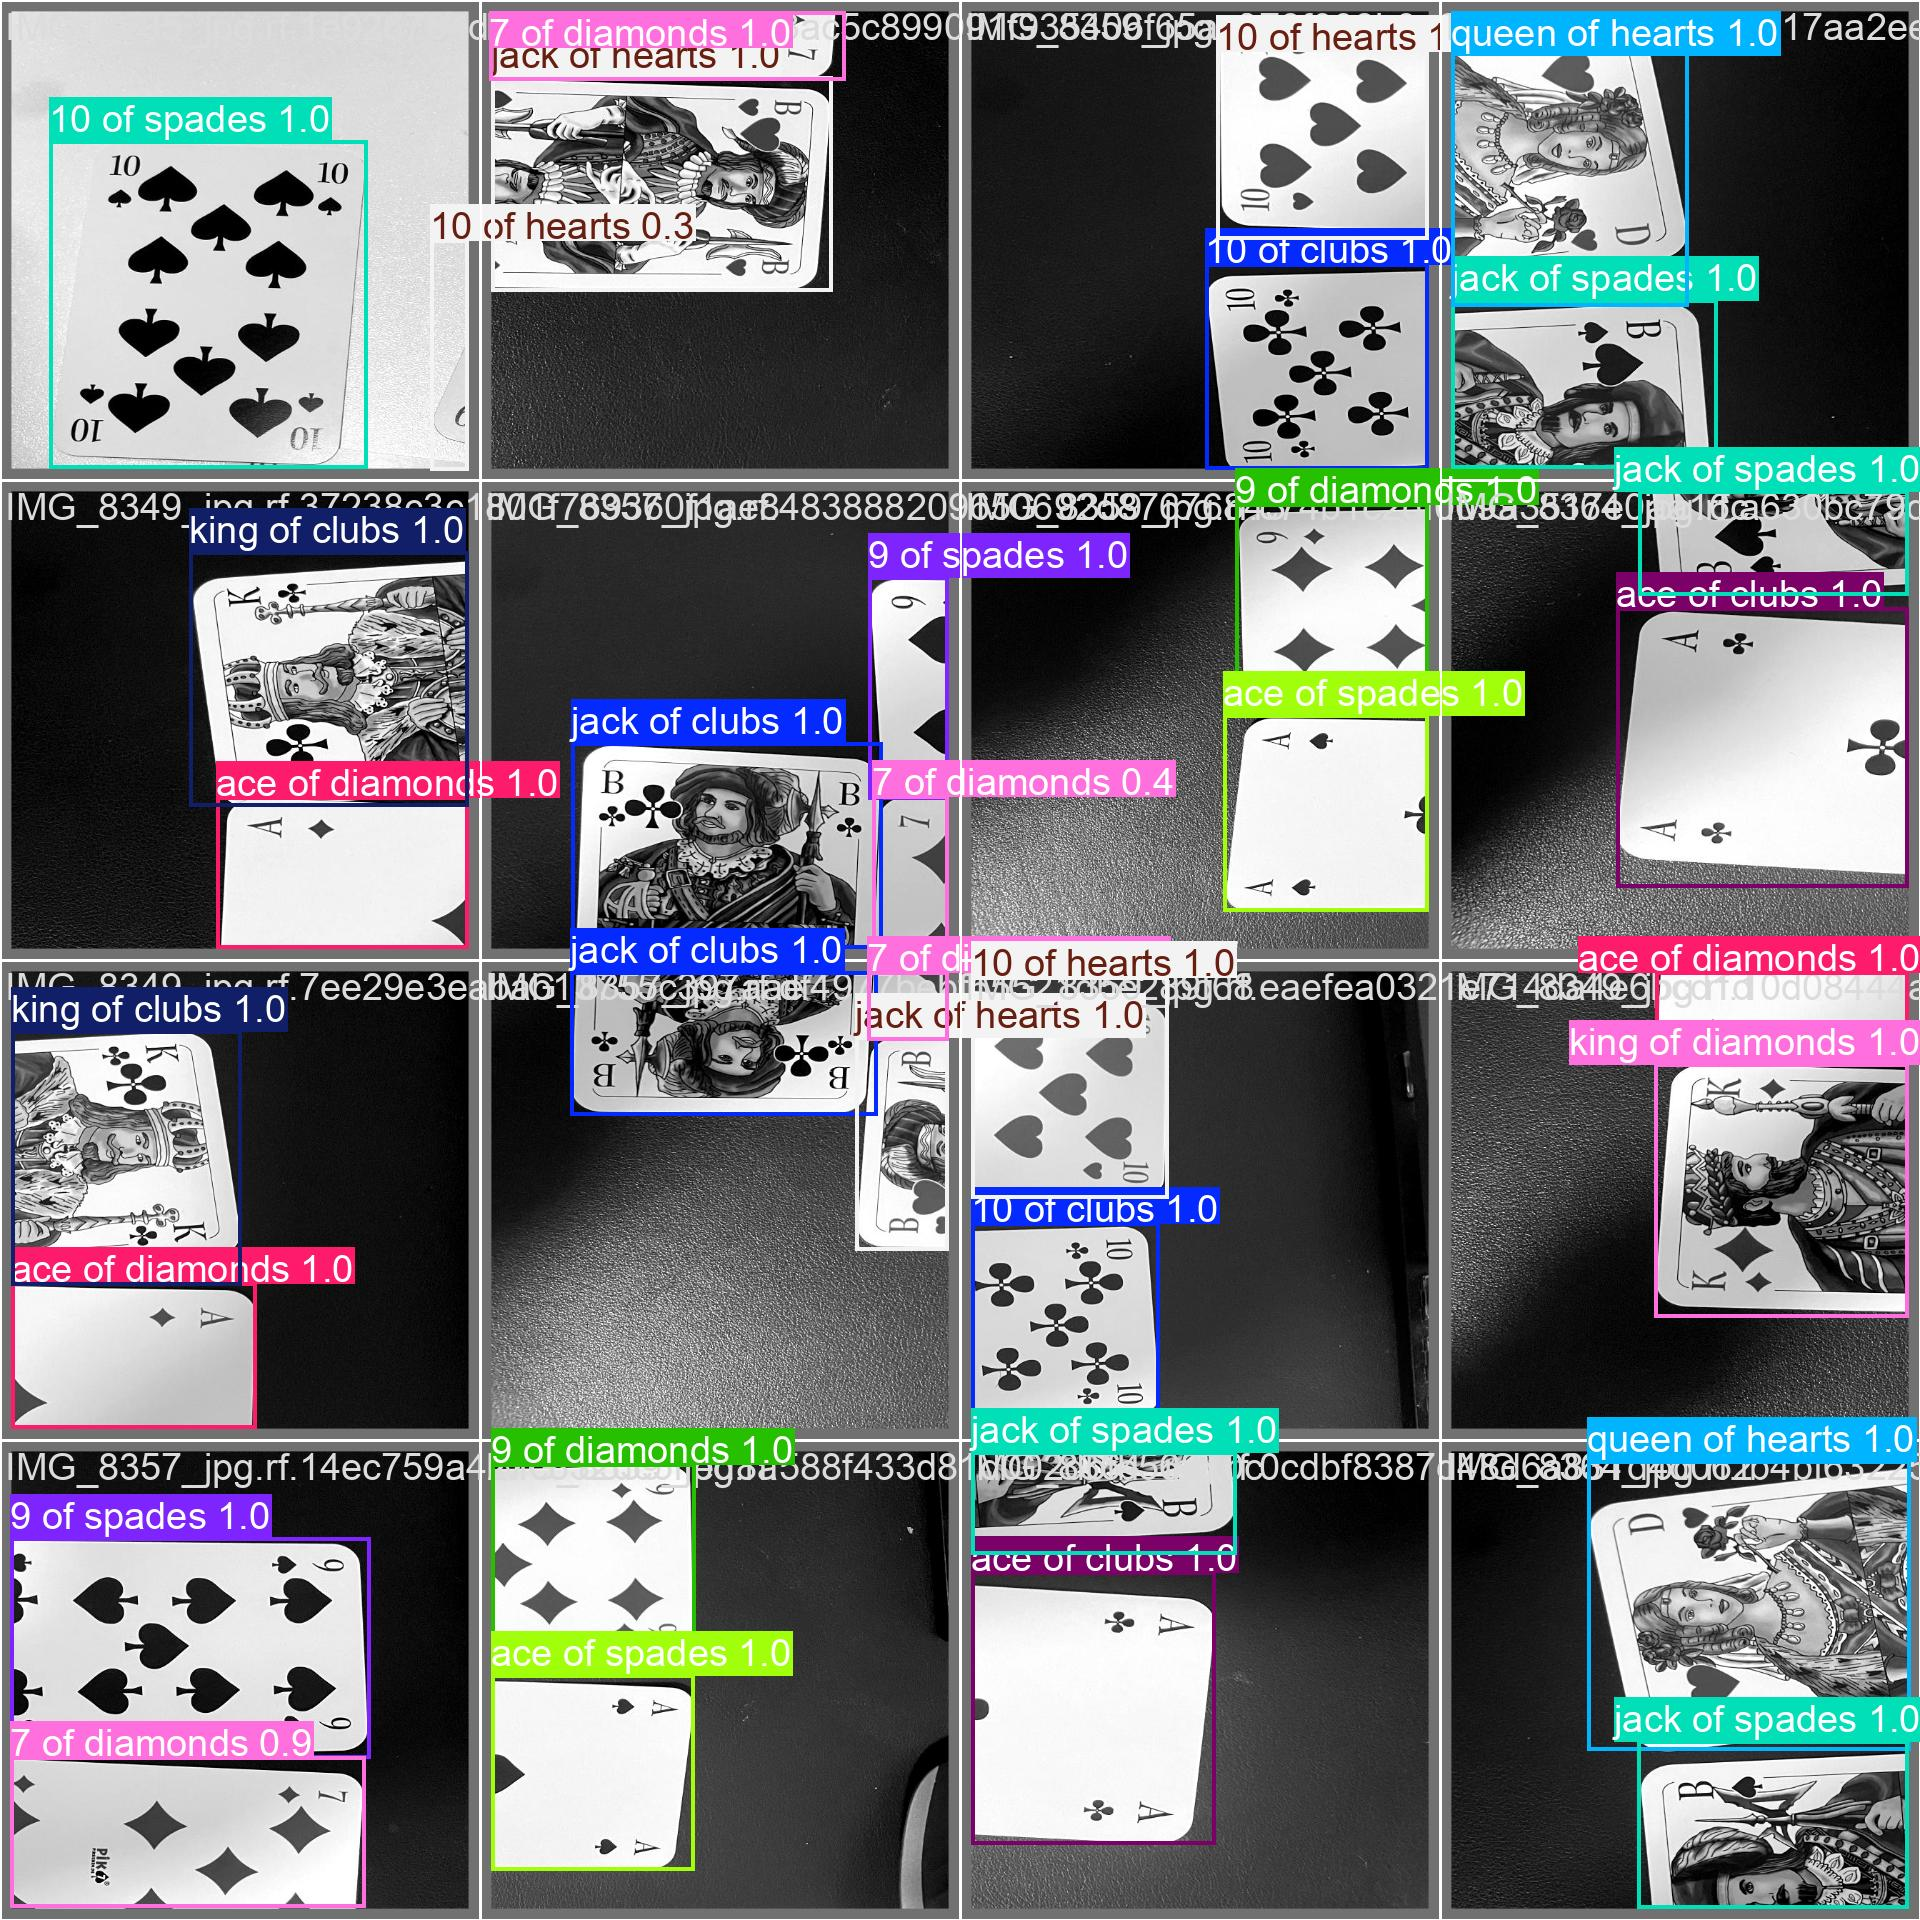

In [10]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [11]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.37 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,425,184 parameters, 0 gradients, 21.4 GFLOPs
val: Scanning /content/datasets/Skat-Card-Object-Detection-1/valid/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100% 64/64 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:03<00:00,  1.29it/s]
                   all         64        143       0.94      0.851      0.892      0.875
           10 of clubs          4          4      0.931        0.5      0.559      0.559
        10 of diamonds          4          4          1      0.371        0.5       0.45
          10 of hearts          6          6      0.988      0.667      0.672      0.655
          10 of spades          1          1      0.905          1      0.995      0.995
            7 of clubs          2          2      0.935          1      0.995      0.995
         7 of diamonds      

## Inference with custom model

In [12]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.37 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,425,184 parameters, 0 gradients, 21.4 GFLOPs

image 1/32 /content/datasets/Skat-Card-Object-Detection-1/test/images/IMG_8284_jpg.rf.33666169d983661f69243655eac3a06d.jpg: 640x640 1 9 of diamonds, 1 king of hearts, 1 king of spades, 15.7ms
image 2/32 /content/datasets/Skat-Card-Object-Detection-1/test/images/IMG_8284_jpg.rf.6f00d74a2540be3148de87de4040c55b.jpg: 640x640 1 8 of clubs, 17.5ms
image 3/32 /content/datasets/Skat-Card-Object-Detection-1/test/images/IMG_8284_jpg.rf.af329cba0c2be5f8162ff6ef4eca7ae3.jpg: 640x640 1 9 of clubs, 1 king of hearts, 15.6ms
image 4/32 /content/datasets/Skat-Card-Object-Detection-1/test/images/IMG_8284_jpg.rf.ea8c029a8c960febd1f626c19b3a3ea7.jpg: 640x640 1 9 of diamonds, 1 king of clubs, 15.6ms
image 5/32 /content/datasets/Skat-Card-Object-Detection-1/test/images/IMG_8336_jpg.rf.25961a3d6f7a38d5b98cd8e34e80a254.jpg: 640x640 1 7 of heart

**NOTE:** Let's take a look at few results.

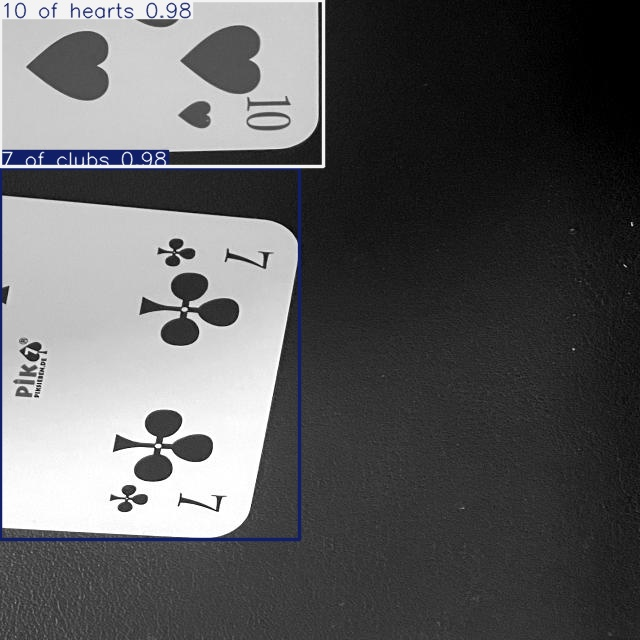

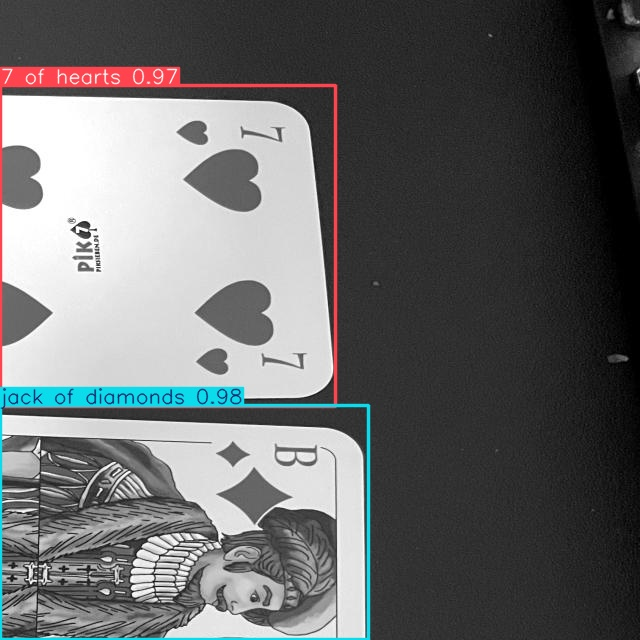

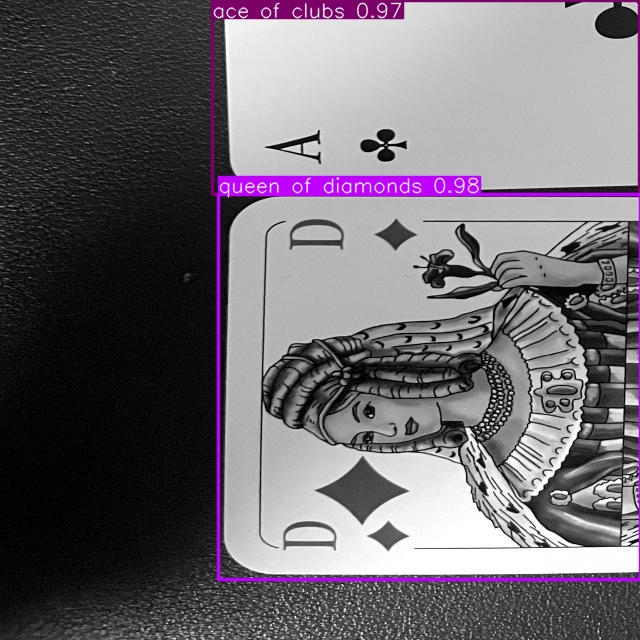

In [13]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

### Now I will use `best.pt` model for prediction to test model
please run yolo_prediction.py file to test the model
### I wil also use  `best.pt` model for to make skat_game strategy
please run skat_game.py file to play skat game